In [2]:
from alpaca.data.historical import StockHistoricalDataClient, CryptoHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('API_KEY')
secret_key = os.getenv('SECRET_KEY')


start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)


# no keys required for etf data
etf_client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)
crypto_client = CryptoHistoricalDataClient(api_key=api_key, secret_key=secret_key)

# Request parameters for etf IBIT
etf_request_params = StockBarsRequest(
                        symbol_or_symbols='IBIT',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )

# Request parameters for crypto BTC/USD
crypto_request_params = CryptoBarsRequest(
                        symbol_or_symbols='BTC/USD',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )

# Get etf and crypto bars
etf_bars = etf_client.get_stock_bars(etf_request_params)
crypto_bars = crypto_client.get_crypto_bars(crypto_request_params)

# Convert to dataframes
etf_df = etf_bars.df.reset_index()
crypto_df = crypto_bars.df.reset_index()

In [490]:
crypto_df = etf_client.get_stock_bars(StockBarsRequest(
                        symbol_or_symbols='BITB',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )).df.reset_index()

In [495]:
import numpy as np

df = etf_df.merge(crypto_df, on='timestamp', suffixes=['_etf', '_crypto'])

df['date'] = df['timestamp'].dt.date
df['log_close_crypto'] = np.log(df['close_crypto'])
df['log_close_etf'] = np.log(df['close_etf'])

In [496]:
df_day = df.groupby('date')

df[['LR_crypto', 'LR_etf']] = df_day\
    [['log_close_crypto', 'log_close_etf']]\
    .diff().T\
    .div(
        df_day['timestamp'].diff().dt.seconds / 60
    )\
    .T
    
df[['LR_crypto', 'LR_etf']] 
# df['LR_crypto'] += np.log(1.00075) # Trading fees (crypto.com)

,LR_crypto,LR_etf
0,NaN,NaN
1,3.052550e-02,0.003674
2,1.425810e-02,0.004530
3,3.639355e-03,0.006065
4,1.750772e-02,0.012021
...,...,...
102044,9.962372e-07,-0.000845
102045,5.479239e-06,0.000956
102046,3.982478e-04,0.000509
102047,1.304432e-05,-0.000003


In [497]:
df['vol_crypto'] = df['LR_crypto'].map(abs)

In [509]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# for date in df['date'].unique():
#     tf = df[df['date'] == date]

#     y = tf['LR_etf']
#     X = sm.add_constant(tf[['LR_crypto', 'trade_count_etf', 'volume_etf']], prepend=False)
#     mod = RollingOLS(exog=X, endog=y, window=10)

#     rolling_res = mod.fit(use_t=True)
#     df.loc[df['date'] == date, ['beta_LR_crypto', 'beta_trade_count_etf', 'beta_volume_etf', 'beta_const']] = rolling_res.params.add_prefix('beta_')

y = df['LR_etf']
X = sm.add_constant(df[['LR_crypto', 'trade_count_etf', 'volume_etf']], prepend=False)
mod = RollingOLS(exog=X, endog=y, window=10)
rolling_res = mod.fit(use_t=True)
df[['beta_LR_crypto', 'beta_trade_count_etf', 'beta_volume_etf', 'beta_const']] = rolling_res.params.add_prefix('beta_')

In [510]:
beta = df[['beta_LR_crypto', 'beta_trade_count_etf', 'beta_volume_etf', 'beta_const']].shift()
design = sm.add_constant(df[['LR_crypto', 'trade_count_etf', 'volume_etf']], prepend=False)
target = df['LR_etf']

In [511]:
import pandas as pd

df['b*LR_crypto'] = pd.concat([beta[f'beta_{col}'] * design[col] for col in design.columns], axis=1)[[0]].sum(axis=1) # no const

In [512]:
import seaborn as sns
import matplotlib.pyplot as plt

df['portfolio'] = (df['LR_etf'] - df['b*LR_crypto'])
df['thres'] = df['portfolio'] > np.log(1.00075)

In [513]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the design matrix and labels
X = beta.values
y = df['thres'].astype(int)  # Convert boolean to int for classification

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and fit the HistGradientBoostingClassifier model
hist_grad_boost = HistGradientBoostingClassifier()
hist_grad_boost.fit(X_train, y_train)

# Make predictions
y_pred = hist_grad_boost.predict(X_test)

# Output the classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     23526
           1       0.00      0.00      0.00      1987

    accuracy                           0.92     25513
   macro avg       0.46      0.50      0.48     25513
weighted avg       0.85      0.92      0.88     25513

[[23525     1]
 [ 1987     0]]


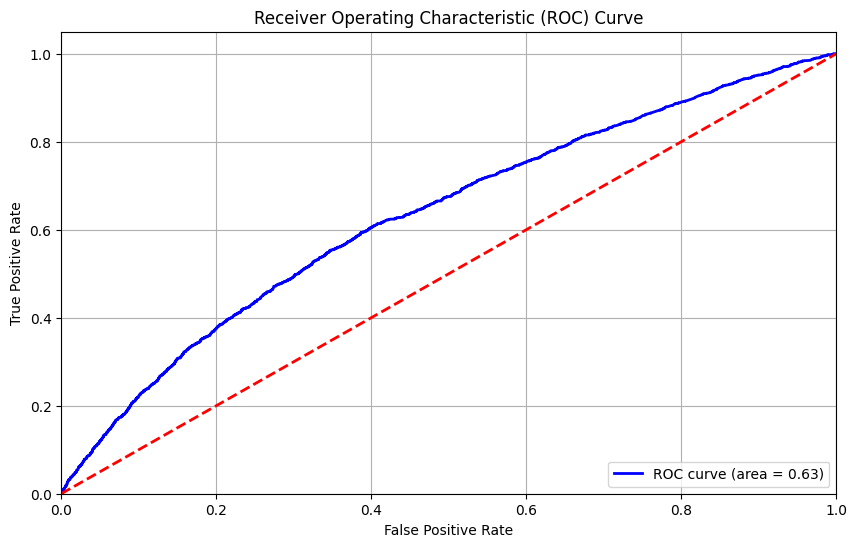

In [514]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, hist_grad_boost.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [516]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the design matrix and labels
X = beta.values
y = df['thres'].astype(int)  # Convert boolean to int for classification

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create and fit the RandomForestClassifier model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions
y_pred = random_forest.predict(X_test)

# Output the classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     47063
           1       0.17      0.00      0.01      3962

    accuracy                           0.92     51025
   macro avg       0.55      0.50      0.48     51025
weighted avg       0.86      0.92      0.89     51025

[[46977    86]
 [ 3944    18]]


In [517]:
# df['trade'] = hist_grad_boost.predict(beta.values)
df['trade'] = random_forest.predict(beta.values)

/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_12488/3473674809.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.iloc[beta.shape[0]//5:][df['trade'] == 1].groupby('date')['portfolio'].sum().plot(kind='hist', bins=600)
/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_12488/3473674809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.iloc[beta.shape[0]//5:][df['trade'] == 1].groupby('date')['portfolio'].sum().plot(kind='kde')


(-0.2, 0.2)

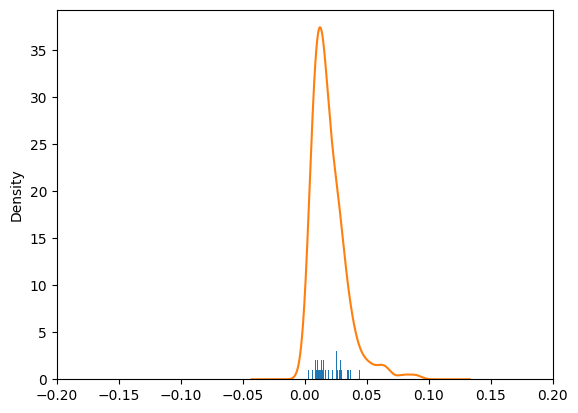

In [518]:
df.iloc[beta.shape[0]//5:][df['trade'] == 1].groupby('date')['portfolio'].sum().plot(kind='hist', bins=600)
df.iloc[beta.shape[0]//5:][df['trade'] == 1].groupby('date')['portfolio'].sum().plot(kind='kde')
plt.xlim(-0.2,0.2)

<Axes: xlabel='date'>

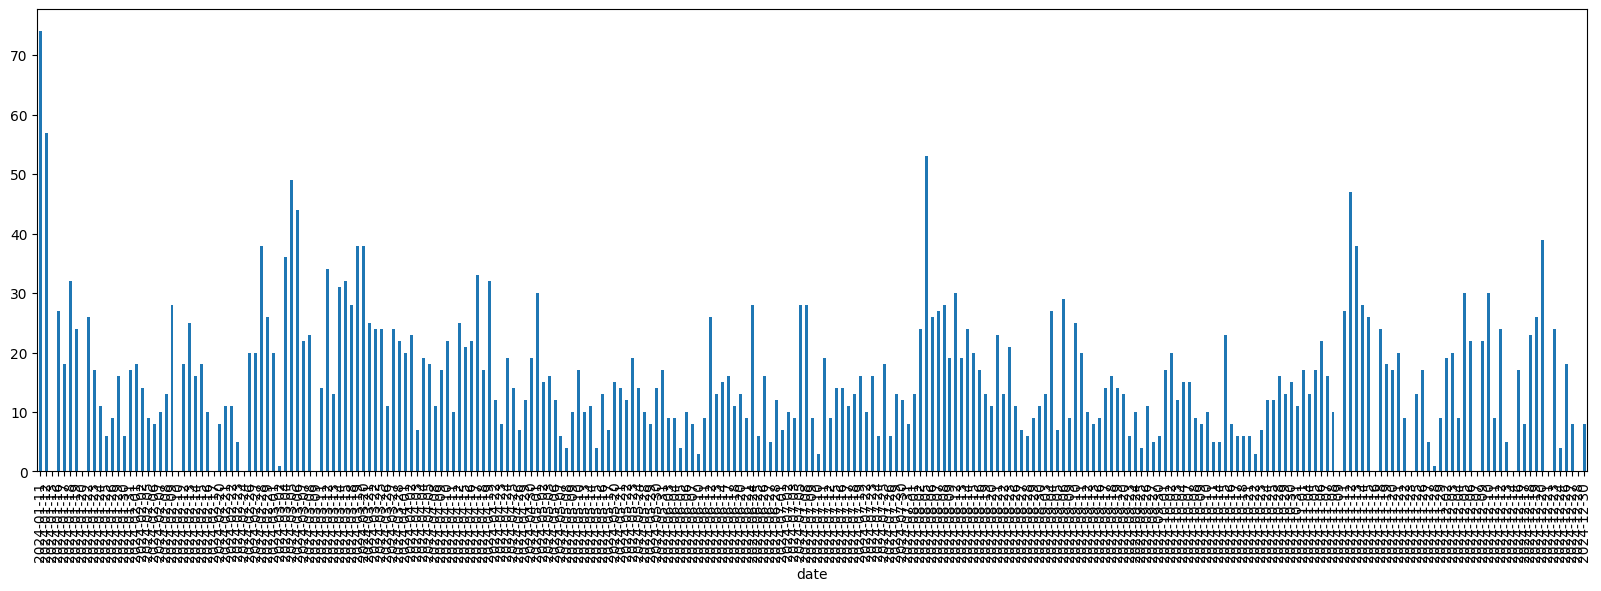

In [519]:
df.groupby('date')['trade'].sum().plot(kind='bar', figsize=(20, 6))

In [520]:
df['daily_return'] = df[df['trade'] == 1].groupby('date')['portfolio'].cumsum()

<Axes: >

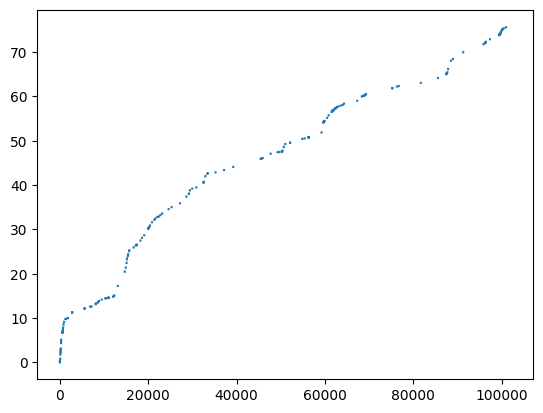

In [521]:
df['daily_return'].cumsum().plot()

In [522]:
x = df.iloc[10000:][df['trade'] == 1].groupby('date')['portfolio'].mean()
x.mean() / x[(x < x.quantile(0.9)) & (x > x.quantile(0.1))].std()

/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_12488/1981362875.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = df.iloc[10000:][df['trade'] == 1].groupby('date')['portfolio'].mean()


8.748904857533807

<Axes: >

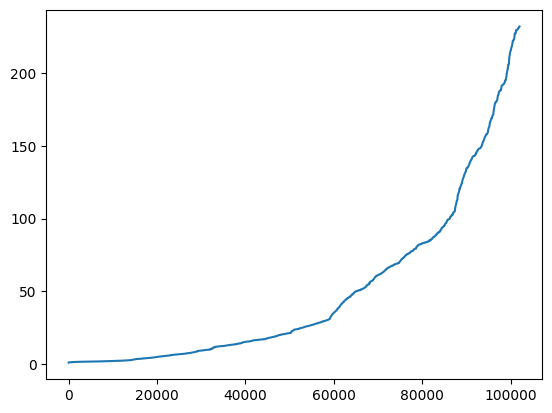

In [523]:
df[df['trade'] == 1]['portfolio'].cumsum().map(np.exp).plot()

<Axes: ylabel='Frequency'>

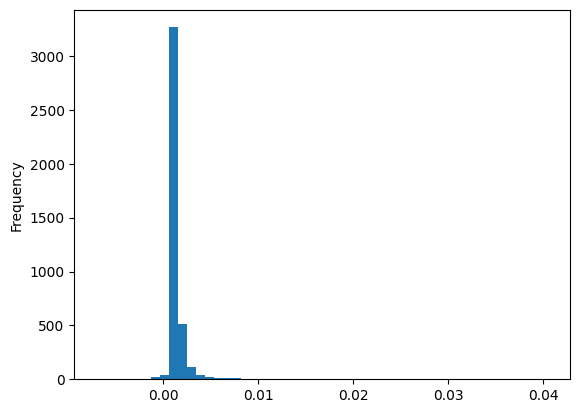

In [527]:
df[df['trade'] == 1]['portfolio'].plot(kind='hist', bins=50)